# Курсовой проект

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

from datetime import datetime

In [2]:
import warnings 
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(16,10))
    
    plt.subplot(121)
    plt.scatter(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    plt.scatter(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загрузка данных.

In [4]:
TRAIN_DATASET_PATH='/Users/kriss_seibel/Desktop/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH='/Users/kriss_seibel/Desktop/real-estate-price-prediction-moscow/test.csv'
SAMPLE_SUBMISSION='/Users/kriss_seibel/Desktop/real-estate-price-prediction-moscow/sample_submission.csv'

In [5]:
train_df=pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
test_df=pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


### 1. EDA

Просмотрим типы наших данных и информацию о них:

In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Признак Id для нас бесполезен, DistrictId - категориальный. Rooms, HouseFloor коррект

In [8]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Видим пропуски в LifeSquare, Healthcare_1, причем в последнем пропусков почти половина. Также в LifeSquare и KitchenSquare неадекватный максимум, больше, чем максимум в Square; в LifeSquare также довольно большая разница между средним значением и медианой. В Floor заметна разница между средним значением и медианой, но это скорее нормально для такого признака, ведь более низкие этажи, очевидно, будут встречаться чаще, так как они есть во всех домахб а более высокие - появляются только в высоких. Также в HouseFloor максимальное значение очень большое - вероятно, также выброс. 

In [9]:
train_df['Id']=train_df['Id'].astype(str)
train_df['DistrictId']=train_df['DistrictId'].astype(str)

*Целевой признак*

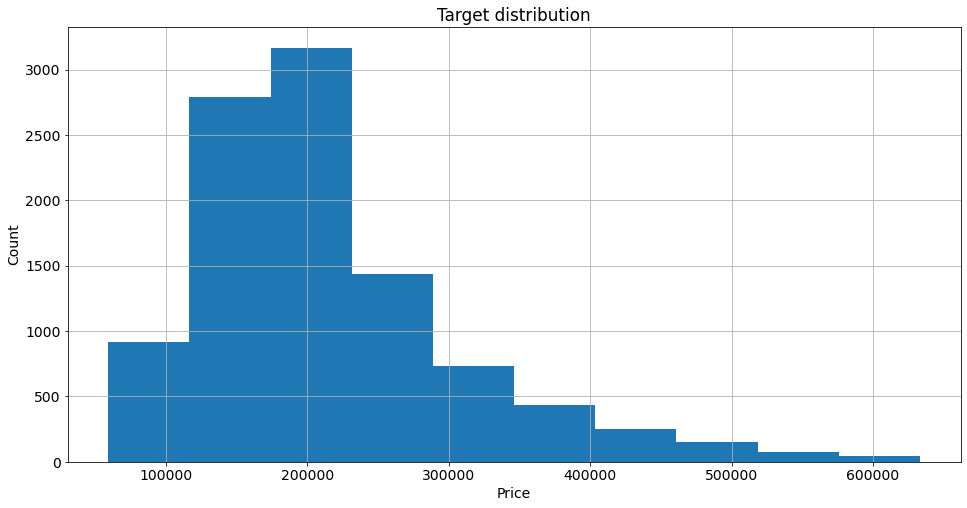

In [10]:
plt.figure(figsize=(16, 8))
train_df['Price'].hist()
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

В целом, распределение цен на большинство объектов выглядит адекватно, но есть хвот справа - можно предположить, что это действительно какая-то недвижимость с более высокими параметрами, или что-то вроде тогоб а не просто ошибка ввода. Хотелось бы посмотреть поближе, чтобы убедиться в этом:

In [11]:
train_df.loc[train_df['Price']>train_df['Price'].quantile(.997)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
32,3876,100,4.0,104.769022,79.316650,8.0,4,8.0,1960,0.200147,B,B,23,3975,8,770.0,2,0,B,600903.828562
347,340,103,4.0,100.501409,59.413974,10.0,3,14.0,2003,0.014423,B,B,19,3806,4,NaN,0,3,B,593618.746096
403,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.825328
940,4971,169,5.0,117.855969,76.561318,9.0,12,14.0,2001,0.178917,B,B,18,3594,4,192.0,1,5,B,608674.130507
1026,7275,95,4.0,99.039161,71.575839,11.0,2,3.0,1942,0.000699,B,B,14,3369,24,4129.0,0,3,B,624156.003381


Действительно, видно, что по параметрам, к примеру, 'Rooms' и 'Square' эти объекты тоже большие

Номинативные переменные

In [12]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [13]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
117      1
209      1
174      1
199      1
196      1
Name: DistrictId, Length: 205, dtype: int64

In [14]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов и пропусков.

In [17]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Пропуски у нас имеются в LifeSquare b Healthcare_1.

*Rooms*

In [18]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Так как крупных обьектов по этому параметру мало, можно просмотреть их, чтобы выяснить, являются ли они ошибочными, ведь в Москве вполне могут быть объекты даже с 19 комнатами - например какая-нибудь элитная недвижимость.

In [19]:
train_df.loc[train_df['Rooms']>=6, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


Если сравнить признаки этих объектов с данными из таблицы decribe, то видно, что по всем остальным параметрам, ктоме количества комнат, их действительно нельзя отнести к крупным. Заменять будем на медиану.

Также у нас имеются объекты с нулевым количеством комнат, и их тоже мало, так что мы вполне можем просмотреть, что они из себя представляют:

In [20]:
train_df.loc[train_df['Rooms']==0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


Мы видим, что это самые разные объекты, с большими и маленьками площадью, ценой и т.д. Заменять будем на медиану.

*Square*

Крупные объекты по этому параметру, скорее всего будут иметь большое количество комнат и большую цену. Максимальная площать у нас - 641 квадратный метр, чтот многовато. Посмотрим, сколько объектов будет иметь площадь хотя бы 250.

In [21]:
train_df.loc[train_df['Square']>=250, :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


Таких объектов всего 4, и по параметрам количества комнат и цене разве что второй объект смотрится адекватно. Будем считать выбросами все объекты с площадью больше 280, заменять будем на медиану.

Теперь посмотрим маленькие объекты. Будем считать, что на площади меньше 10 кв. м. вряд ли можно жить. Посмотрим, столько у нас таких объектов, и что они из себя представляют.

In [22]:
train_df.loc[train_df['Square']<10, :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
1401,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083


Таких объектов всего 5, причем все они даже меньше 6 кв. м., и почти все имеют довольно приличную стоимость. Все эти площади будем заменять на медиану.

*Kitchen Square*

Просмотрим частоту площадей для кухни

In [23]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

Последнее более-менее популярное значение для площади кухни - 19 кв.м. В принципе, такое можно себе представить, в каком-то дорогом доме. Посмотрим, что это за объекты.

In [24]:
train_df.loc[train_df['KitchenSquare']==19, :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1606,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979
1949,14973,125,3.0,120.864529,65.758589,19.0,7,10.0,1999,0.194489,B,B,47,8004,3,125.0,3,5,B,536670.672784
4849,12780,44,3.0,73.091373,72.976112,19.0,18,25.0,2013,0.122190,B,B,25,4724,2,1308.0,1,3,B,394927.323339
5631,716,113,3.0,125.287183,127.477137,19.0,26,24.0,2017,0.050756,B,B,24,5469,1,145.0,0,1,B,522197.035995
5924,13818,7,3.0,115.254741,56.404018,19.0,16,17.0,2012,0.035145,B,B,42,9292,3,2620.0,0,3,B,565355.938997


Объекты действительно выглядят адекватно - здесь много комнат, большая общая площадь, выцсокая цена. Примем значение 19 за верхнюю границу, все, что выше будем заменять на медиану.

In [25]:
train_df.loc[train_df['KitchenSquare']>19, 'KitchenSquare']=train_df['KitchenSquare'].median()

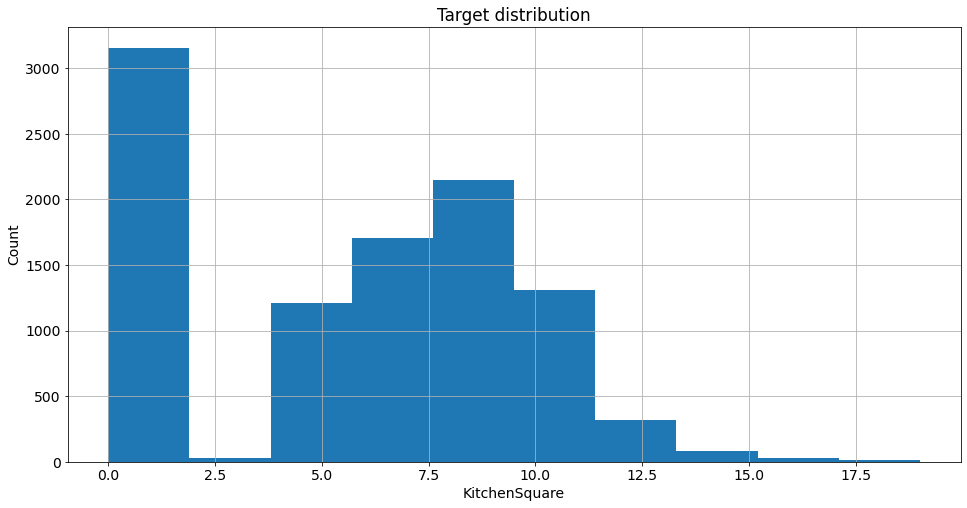

In [26]:
plt.figure(figsize=(16, 8))
train_df['KitchenSquare'].hist()
plt.ylabel('Count')
plt.xlabel('KitchenSquare')
plt.title('Target distribution')
plt.show()

Мы видим большое количество кухонь в диапазоне от 0 до 2 кв.м., выглядит это странновато. Попробуем посмотреть, что это за объекты.

In [27]:
train_df.loc[train_df['KitchenSquare']<=2, :].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.892020
30,5931,23,1.0,43.033398,NaN,1.0,3,4.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,72659.971575


Мы видим самые разные объекты, и большие, и маленькие, и в них точно не во всех настолько крошечные кухни. Попробуем заменить на медиану.

*LifeSquare*

In [28]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,1.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,1.0
9,79.867477,75.085125,1.0


Общая площадь - это жилая площадь + площадь кухни + площадь туалета, ванной, балкона, кладовой, коридоров и т.д. Исходя из этого, а также того, что по общей площади и площади кухни пропусков у нас нет, будем рассчитывать жилую площадь. В качество площади прочих помещений я возьму 7 кв.м. 

Кроме того, у нас имеется неадекватный максимум. Так как мы считаем максимально возможносй жилой площадью 250 кв. м., а кухни 19 квадратных метров, то будем считать, что жилая площадь не может быть больше 220 квадратных метров. 

Также у нас есть неадекватный минимум - так как мы решили, что на площади меньше 10 квадратных метров жить нельзя, и кухня вряд ли может быть меньше 2 квадратных метров, будем считать, что наша жилая площадь не может быть меньше 6 квадратных метров.

Все объекты с жилой площадью меньше 6 и больше 220 кв. м. будем заполнять медианой.

*HouseFloor, Floor*

In [29]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [30]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

Мы видим дома с 0 этажами, что невозможно, а также дома с количеством этажей 99 и 117, но в самом высоком здании Москвы всего 95 этажей. Будем заменять такие значения медианой. Остальное выглядит адекватно. 

In [31]:
(train_df['Floor']>train_df['HouseFloor']).sum()

1825

Также у нас есть 1825 объектов с количеством этажей в доме меньшим, чем этаж, на котором собственно находится объект. Заменим эти значения на случайный этаж в пределах этажности указанного дома.

*HouseYear*

In [32]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

Нижняя граница выглядит адекватно, но у нас есть два объекта со значениями года постройки 20052011 и 4968, такие значения будем заменять. Верхней границей установим текущий год, все что больше, будем заменять на медиану.

HealthCare 1.

<AxesSubplot:>

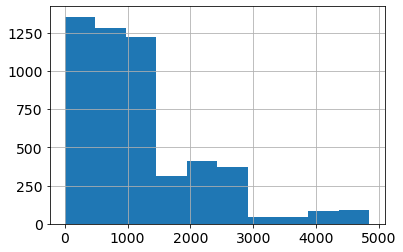

In [33]:
train_df['Healthcare_1'].hist()

Точно неясно, что конкретно означает этот признак, поэтому сложно судить, насколько адекватная столь высокая частотность слева. Попробуем заполнить попуски случайными значениями в пределах 2-3 квантилей.

In [34]:
train_df['Healthcare_1'].mean()

1142.9044598231449

In [35]:
train_df['Healthcare_1'].median()

900.0

In [36]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modas=None
        
        self.num_features=None
        self.cat_features=None
        
    def fit(self, X):
        self.medians=X.median()
        self.modas=X.mode()
        
        self.num_features=['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Ecology_1', 'Social_1', 'Social_2',
                           'Social_3', 'Helthcare_2', 'Shops_1']
        self.cat_features=['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']
        
    def transform(self, X):
        
        #Rooms
        X['Rooms_outlier']=0
        X.loc[(X['Rooms']==0) | (X['Rooms']>=6), 'Rooms_outlier']=1
        
        X.loc[X['Rooms']==0, 'Rooms']=1
        X.loc[(X['Rooms'].isna()) | (X['Rooms']>=6), 'Rooms']=self.medians['Rooms']
        
        #Square
        X['Square_outlier']=0
        X.loc[(X['Square']<10) | (X['Square']>280), 'Square_outlier']=1
        
        X.loc[(X['Square'].isna()) | (X['Square']<10) | (X['Square']>280), 'Square']=self.medians['Square']
        
        #KitchenSquare
        condition=(X['KitchenSquare'].isna()) | (X['KitchenSquare']>19) | (X['KitchenSquare']<=2)
        
        X.loc[condition, 'KitchenSquare']=self.medians['KitchenSquare']
        
         #LifeSquare
        X['LifeSquare_nan']=X['LifeSquare'].isna()*1
        condition1=(X['LifeSquare'].isna()) & (~X['Square'].isna())&(~X['KitchenSquare'].isna())
        condition2=(X['LifeSquare']<6) | (X['LifeSquare']>220)
        
        X.loc[condition1, 'LifeSquare']=X.loc[condition1, 'Square']-X.loc[condition1, 'KitchenSquare']-7
        X.loc[condition2, 'LifeSquare']=self.medians['LifeSquare']
        
        #HouseFloor, Floor
        X['HouseFloor_outlier']=0
        X.loc[(X['HouseFloor']==0) | (X['HouseFloor']>95), 'HouseFloor_outlier']=1
        X.loc[X['Floor']>X['HouseFloor'], 'HouseFloor_outlier']=1
        
        X.loc[(X['HouseFloor']==0) | (X['HouseFloor']>95), 'HouseFloor']=self.medians['HouseFloor']
        floor_outliers=X.loc[X['Floor']>X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor']=X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        #HouseYear
        current_year=datetime.now().year
        X['HouseYear_outlier']=0
        X.loc[X['HouseYear']>current_year, 'HouseYear_outlier']=1
        
        X.loc[X['HouseYear']>current_year, 'HouseYear']=self.medians['HouseYear']
        
        #Healthcare_1
        X['Healthcare_1_outlier']=0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_outlier']=1
        
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1']=X.loc[X['Healthcare_1'].isna(), 'Healthcare_1']\
                .apply(lambda x: random.randint(X['Healthcare_1'].quantile(.25), X['Healthcare_1'].quantile(.75)))

        
        X[self.num_features].fillna(self.medians, inplace=True)
        X[self.cat_features].fillna(self.modas, inplace=True)
        
        return X

### 3. Построение новых признаков.

Категориальные признаки переведем в бинарные.

*Dummies*

In [37]:
binary_to_numbers={'A':0, 'B':1}

train_df['Ecology_2']=train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3']=train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2']=train_df['Shops_2'].replace(binary_to_numbers)

*DistrictSize, IsDistrictLarge*

In [38]:
district_size=train_df['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 
                                                                                 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [39]:
train_df=train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,1,11,3097,0,NaN,0,0,1,305018.871089,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,30,6207,1,1183.0,1,0,1,177734.553407,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,33,5261,0,240.0,3,1,1,282078.720850,652
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,1,264,0,NaN,0,1,1,168106.007630,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,33,8667,2,NaN,0,6,1,343995.102962,89


In [40]:
(train_df['DistrictSize']>100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [41]:
train_df['IsDistrictLarge']=(train_df['DistrictSize']>100).astype(int)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,1,305018.871089,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,1,177734.553407,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,1,282078.720850,652,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,1,168106.007630,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,1,343995.102962,89,0


*MedPriceByRooms*

In [42]:
med_price_by_rooms=train_df.groupby('Rooms', as_index=False).agg({'Price':'median'})\
                                                                    .rename(columns={'Price':'MedPriceByRooms'})
med_price_by_rooms

,Rooms,MedPriceByRooms
0,0.0,214937.068787
1,1.0,154979.497993
2,2.0,200320.754636
3,3.0,268723.157677
4,4.0,377524.231990
5,5.0,455355.638212
6,6.0,229661.964416
7,10.0,244797.297328
8,19.0,78364.616704


In [43]:
train_df=train_df.merge(med_price_by_rooms, on='Rooms', how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByRooms
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,1,305018.871089,851,1,268723.157677
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.553407,78,0,154979.497993
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,1,282078.720850,652,1,268723.157677
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,1,168106.007630,652,1,154979.497993
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,1,343995.102962,89,0,200320.754636
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,...,5776,1,2078.0,2,4,1,161044.944138,97,0,268723.157677
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,...,4860,1,80.0,0,3,1,142402.739272,104,1,154979.497993
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,...,7687,11,176.0,5,5,1,326174.175191,67,0,200320.754636
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,...,264,0,NaN,0,1,1,160400.401732,652,1,154979.497993
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,...,1564,0,540.0,0,0,1,194756.023945,511,1,268723.157677


*Med Price By District*

In [44]:
med_price_by_district=train_df.groupby('DistrictId', as_index=False).agg({'Price':'median'})\
                                                                    .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head(5)

,DistrictId,MedPriceByDistrict
0,0,165963.054142
1,1,183663.443595
2,10,217749.656911
3,100,234032.836228
4,101,184276.502773


In [45]:
train_df=train_df.merge(med_price_by_district, on='DistrictId', how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByRooms,MedPriceByDistrict
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,NaN,0,0,1,305018.871089,851,1,268723.157677,146171.433190
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,1,177734.553407,78,0,154979.497993,183678.134031
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,652,1,268723.157677,183663.443595
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,0,NaN,0,1,1,168106.007630,652,1,154979.497993,183663.443595
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,NaN,0,6,1,343995.102962,89,0,200320.754636,181706.718894
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,...,1,2078.0,2,4,1,161044.944138,97,0,268723.157677,178829.166450
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,...,1,80.0,0,3,1,142402.739272,104,1,154979.497993,208164.464747
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,...,11,176.0,5,5,1,326174.175191,67,0,200320.754636,318772.374740
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,...,0,NaN,0,1,1,160400.401732,652,1,154979.497993,183663.443595
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,...,0,540.0,0,0,1,194756.023945,511,1,268723.157677,168980.370846


*Med Price By Floor Year*

In [46]:
def floor_to_cat(X):
    bins=[0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat']=pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def house_year_to_cat(X):
    bins=[X['HouseYear'].min(), 1917, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['house_year_cat']=pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['house_year_cat'].fillna(-1, inplace=True)
    return X

In [47]:
train_df=floor_to_cat(train_df)
train_df=house_year_to_cat(train_df)

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByRooms,MedPriceByDistrict,floor_cat,house_year_cat
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,851,1,268723.157677,146171.433190,1,6.0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,78,0,154979.497993,183678.134031,2,3.0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,652,1,268723.157677,183663.443595,0,4.0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,652,1,154979.497993,183663.443595,3,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,89,0,200320.754636,181706.718894,4,3.0


In [48]:
med_price_by_floor_year=train_df.groupby(['floor_cat', 'house_year_cat'], as_index=False).agg({'Price':'median'})\
                                                                    .rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head(10)

,floor_cat,house_year_cat,MedPriceByFloorYear
0,0,0.0,165951.783553
1,0,1.0,402075.431031
2,0,2.0,467230.539057
3,0,3.0,177933.328473
4,0,4.0,204940.082609
5,0,5.0,238247.421498
6,0,6.0,159052.470665
7,1,0.0,385333.034575
8,1,1.0,321497.418777
9,1,2.0,509182.957515


In [49]:
train_df=train_df.merge(med_price_by_floor_year, on=['house_year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByRooms,MedPriceByDistrict,floor_cat,house_year_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,851,1,268723.157677,146171.433190,1,6.0,161246.069193
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,78,0,154979.497993,183678.134031,2,3.0,188098.168461
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,652,1,268723.157677,183663.443595,0,4.0,204940.082609
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,1,168106.007630,652,1,154979.497993,183663.443595,3,3.0,185190.984473
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,89,0,200320.754636,181706.718894,4,3.0,181281.815896


In [50]:
class FeatureGenerator():
    
    def __init__(self):
        self.DistrictId_counts=None
        self.binary_to_numbers=None
        self.med_price_by_rooms=None
        self.med_price_by_district=None
        self.med_price_by_floor_year=None
        self.house_year_max=None
        self.floor_max=None
        self.house_year_min=None
        self.district_size=None

    def fit(self, X, y=None):
        
        X=X.copy()
        
        # Binary features
        self.binary_to_numbers={'A': 0, 'B': 1}
        
        # District ID
        self.district_size=X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId',
                                                                                    'DistrictId':'DistrictSize'})
                
        # Med Price By District
        df=X.copy()
        
        if y is not None:
            df['Price']=y.values
            
            self.med_price_by_district=df.groupby('DistrictId', as_index=False).agg({'Price':'median'})\
                                                                    .rename(columns={'Price':'MedPriceByDistrict'})
            self.med_price_by_district_median=self.med_price_by_district['MedPriceByDistrict'].median()
            
        #Med Price By Rooms
        if y is not None:
            df['Price']=y.values
            
            self.med_price_by_rooms=df.groupby('Rooms', as_index=False).agg({'Price':'median'})\
                                                                        .rename(columns={'Price':'MedPriceByRooms'})
            self.med_price_by_rooms_median=self.med_price_by_rooms['MedPriceByRooms'].median()
        
            
        # Med Price By Floor, Year
        if y is not None:
            self.floor_max=df['Floor'].max()
            self.floor_min=df['Floor'].min()
            self.house_year_max=df['HouseYear'].max()
            self.house_year_min=df['HouseYear'].min()
            
            df['Price']=y.values
            
            df=self.floor_to_cat(df)
            df=self.year_to_cat(df)
            self.med_price_by_floor_year=df.groupby(['year_cat', 'floor_cat'], as_index=False)\
                                            .agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median=self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2']=X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3']=X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2']=X['Shops_2'].map(self.binary_to_numbers)
        
        # District Id, Is District Large
        X=X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district']=0
        X.loc[X['DistrictSize'].isna(), 'new_district']=1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge']=(X['DistrictSize']>100).astype(int)
        
        # More categorical features
        X=self.floor_to_cat(X)
        X=self.year_to_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X=X.merge(self.med_price_by_district, on='DistrictId', how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
                
        if self.med_price_by_rooms is not None:
            X=X.merge(self.med_price_by_rooms, on='Rooms', how='left')
            X['MedPriceByRooms'].fillna(self.med_price_by_rooms_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X=X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins=[1, 3, 5, 9, 15, self.floor_max]
        X['floor_cat']=pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins=[self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat']=pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 4. Отбор признаков.

In [51]:
feature_names=['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
               'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 
               'Shops_1', 'Shops_2']
new_feature_names=['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'Healthcare_1_outlier', 'DistrictSize', 
                   'IsDistrictLarge','MedPriceByRooms', 'MedPriceByDistrict', 'MedPriceByFloorYear']
target_name=['Price']

### 5. Разбиение на train и test.

In [52]:
train_df=pd.read_csv(TRAIN_DATASET_PATH)
test_df=pd.read_csv(TEST_DATASET_PATH)

X=train_df.drop(columns=target_name)
y=train_df[target_name]

In [53]:
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)

In [54]:
preprocessor=DataPreprocessing()
preprocessor.fit(X_train)

X_train=preprocessor.transform(X_train)
X_valid=preprocessor.transform(X_valid)
test_df=preprocessor.transform(test_df)

In [55]:
features_gen=FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train=features_gen.transform(X_train)
X_valid=features_gen.transform(X_valid)
test_df=features_gen.transform(test_df)

In [56]:
X_train=X_train[feature_names+new_feature_names]
X_valid=X_valid[feature_names+new_feature_names]
test_df=test_df[feature_names+new_feature_names]

In [57]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 6. Построение модели.

*Обучение*

In [58]:
gb_model=GradientBoostingRegressor(criterion='mse', max_depth=3, min_samples_leaf=40, random_state=1,
                                                                                                n_estimators=60)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', min_samples_leaf=40, n_estimators=60,
                          random_state=1)

*Оценка модели*

Train R2:	0.752
Test R2:	0.726


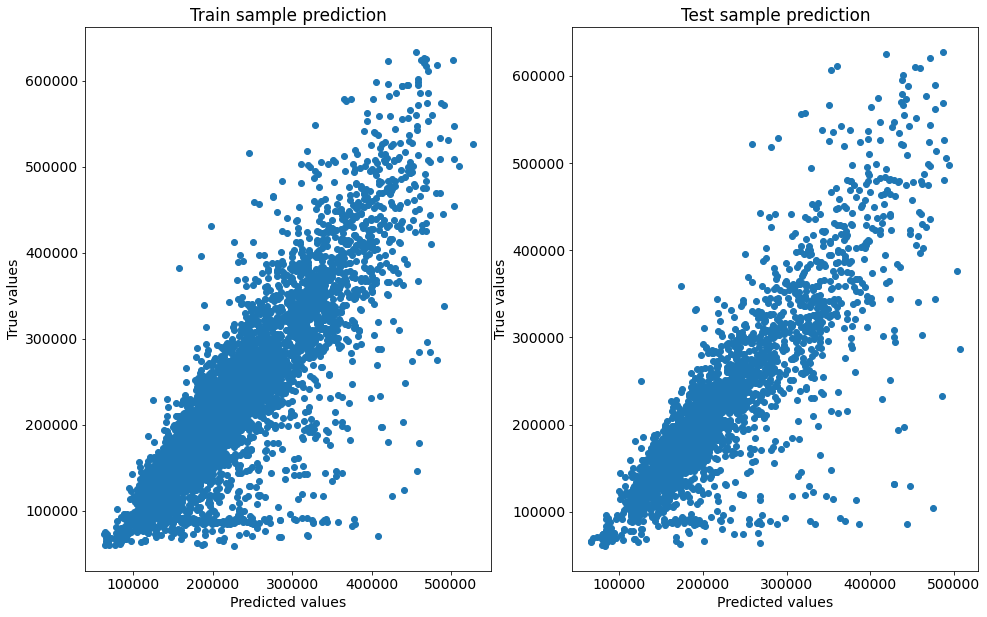

In [59]:
y_train_preds=gb_model.predict(X_train)
y_test_preds=gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

*Кросс-валидация*

In [60]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, 
                                                                                                  random_state=1))
cv_score

array([0.72173412, 0.74007095, 0.70872119, 0.72700235, 0.69180491])

In [61]:
cv_score.mean()

0.7178667023779228

*Важность признаков*

In [62]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.491682
24,MedPriceByDistrict,0.338856
21,DistrictSize,0.054996
25,MedPriceByFloorYear,0.024094
10,Social_1,0.017245
0,Rooms,0.017106
12,Social_3,0.016182
11,Social_2,0.009457
13,Healthcare_1,0.007673
23,MedPriceByRooms,0.005096


Модель показывает достаточно хороший результат на тесте, разница между тренировочными и тестовыми данными небольшая. Кросс-валидация показывает средний результат очень близкий к результату теста. По важности признаков несколько беспокоит вклад признака Square, но модель работает неплохо.

### 7. Прогнозирование на тестовом датасете.

In [63]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_outlier,DistrictSize,IsDistrictLarge,MedPriceByRooms,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970.0,0.036122,1,1,...,1,0,0,0,0,73.0,0,155195.082907,207103.209097,190505.153524
1,1.0,42.493907,42.568133,10.0,7,17.0,2017.0,0.072158,1,1,...,0,0,0,0,1,168.0,1,155195.082907,159823.272996,175771.383549
2,2.0,59.463678,43.463678,9.0,19,19.0,1977.0,0.211401,1,1,...,1,0,0,1,1,607.0,1,200377.728472,145040.956302,171739.199220
3,3.0,49.646030,33.893825,6.0,2,2.0,1965.0,0.014073,1,1,...,1,0,0,0,1,386.0,1,268170.850822,114943.898699,178894.793693
4,1.0,53.837056,40.837056,6.0,8,17.0,1977.0,0.309479,1,1,...,1,0,0,1,0,75.0,0,155195.082907,220191.322074,190467.027727


In [64]:
submit=pd.read_csv(SAMPLE_SUBMISSION)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [65]:
predictions=gb_model.predict(test_df)
predictions

array([168234.06774355, 120270.32172919, 158642.72748979, ...,
       145346.82586723, 187986.09933597, 236348.62409803])

In [66]:
submit['Price']=predictions
submit.head()

,Id,Price
0,4567,168234.067744
1,5925,120270.321729
2,960,158642.727490
3,3848,119616.764576
4,746,211968.347698


In [67]:
submit.to_csv('gb_submit.csv', index=False, sep=',')